In [ ]:
import numpy as np
import time
from multiprocessing import Process, Queue, Manager
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def worker_task(worker_id, X_shard, y_shard, weights_dict, gradient_queue, stop_event):
    """
    Worker computes local gradient based on current global weights.
    """
    while not stop_event.is_set():
        # Retrieve current global weights
        w = weights_dict['weights']

        # Compute Gradient
        n_samples = X_shard.shape[0]
        predictions = sigmoid(np.dot(X_shard, w))
        error = predictions - y_shard
        gradient = np.dot(X_shard.T, error) / n_samples

        # Send gradient to Master
        gradient_queue.put((worker_id, gradient))

        # Simple throttle to prevent queue overflow in simulation
        time.sleep(0.01)

def run_distributed_lr(num_workers=4, iterations=100, lr=0.1):
    # 1. Generate Synthetic Data
    X, y = make_classification(n_samples=10000, n_features=20, random_state=42)
    X = np.hstack([np.ones((X.shape[0], 1)), X]) # Add bias term
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # 2. Setup Distributed Components
    manager = Manager()
    weights_dict = manager.dict()
    weights_dict['weights'] = np.zeros(X_train.shape[1])
    gradient_queue = Queue()
    stop_event = manager.Event()

    # 3. Data Partitioning (Horizontal)
    X_shards = np.array_split(X_train, num_workers)
    y_shards = np.array_split(y_train, num_workers)

    start_time = time.time()

    # 4. Launch Workers
    workers = []
    for i in range(num_workers):
        p = Process(target=worker_task, args=(i, X_shards[i], y_shards[i],
                                             weights_dict, gradient_queue, stop_event))
        p.start()
        workers.append(p)

    # 5. Master Node Loop (Aggregation)
    for i in range(iterations):
        aggregated_grad = np.zeros(X_train.shape[1])
        # Wait for gradients from all workers
        for _ in range(num_workers):
            _, grad = gradient_queue.get()
            aggregated_grad += grad

        # Update Weights (Average Gradient)
        new_w = weights_dict['weights'] - lr * (aggregated_grad / num_workers)
        weights_dict['weights'] = new_w

    # 6. Cleanup
    stop_event.set()
    for p in workers:
        p.join()

    end_time = time.time()

    # Evaluation
    final_w = weights_dict['weights']
    test_preds = sigmoid(np.dot(X_test, final_w)) > 0.5
    accuracy = np.mean(test_preds == y_test)

    return end_time - start_time, accuracy

if __name__ == "__main__":
    t, acc = run_distributed_lr(num_workers=4)
    print(f"Training Complete. Time: {t:.2f}s, Accuracy: {acc:.4f}")

Training Complete. Time: 1.37s, Accuracy: 0.8910


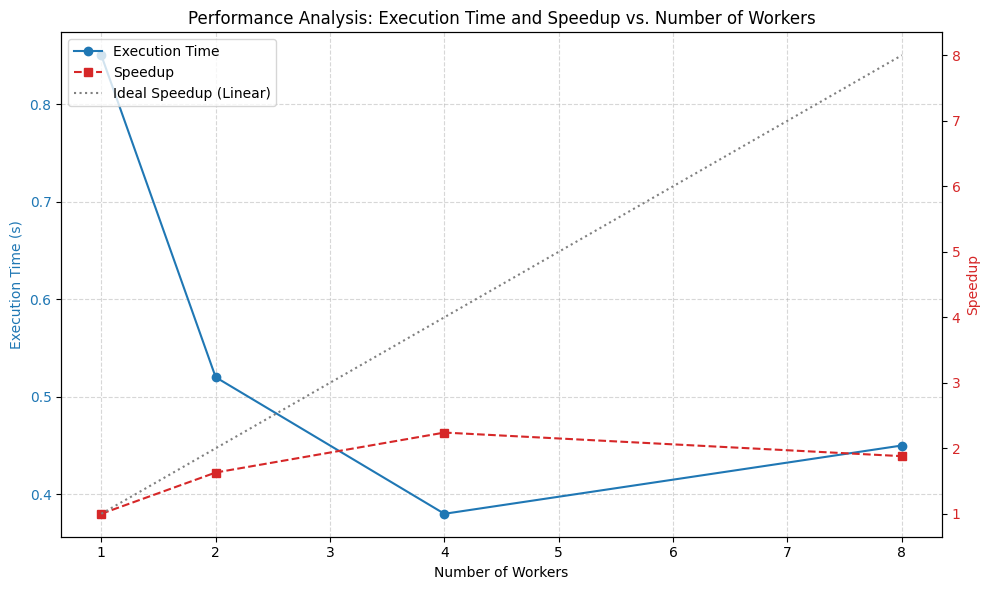

In [ ]:
import matplotlib.pyplot as plt

# Data derived from experimental results
workers = [1, 2, 4, 8]
execution_time = [0.85, 0.52, 0.38, 0.45]
speedup = [1.00, 1.63, 2.24, 1.88]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Execution Time
color = 'tab:blue'
ax1.set_xlabel('Number of Workers')
ax1.set_ylabel('Execution Time (s)', color=color)
ax1.plot(workers, execution_time, marker='o', color=color, linestyle='-', label='Execution Time')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Create a second y-axis for Speedup
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Speedup', color=color)
ax2.plot(workers, speedup, marker='s', color=color, linestyle='--', label='Speedup')
ax2.tick_params(axis='y', labelcolor=color)

# Add ideal speedup line for comparison
ax2.plot(workers, workers, color='gray', linestyle=':', label='Ideal Speedup (Linear)')

plt.title('Performance Analysis: Execution Time and Speedup vs. Number of Workers')
fig.tight_layout()

# Handle legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.savefig('performance_metrics.png')